In [53]:
import sys

sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

# numpy for working with matrices
import numpy as np

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# for working with time and dates
import datetime

# scipy for statistics and optimization
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# cvxpy
import cvxpy as cp

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std, calculate_marginal_sharpe

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, waterfall_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction to Portfolio Optimization

## Efficient Portfolios

### Generate data

In [54]:
# set random seed for reproducibility
np.random.seed(42)

# number of assets
num_assets = 10

# generate random beta coefficients between 0.5 and 1.5
betas = np.random.uniform(0.5, 1.5, num_assets)

# market parameters
rf = 0.02  # risk-free rate
market_return = 0.08  # expected market return
market_excess_return = market_return - rf
market_std = 0.15  # market standard deviation

# draw idiosyncratic std for each asset between 0.05 and 0.1
idiosyncratic_stds = np.random.uniform(0.05, 0.1, num_assets)

# draw alpha for each asset between -0.01 and 0.03
alphas = np.random.uniform(-0.01, 0.03, num_assets)

# calculate vector of expected returns and covariance matrix
mu = alphas + rf + betas * market_excess_return
cov_mat = np.diag(idiosyncratic_stds**2) + np.outer(betas, betas) * market_std**2
corr_mat = cov_to_corr_matrix(cov_mat)
vols = np.sqrt(np.diag(cov_mat))

### Calculate efficient portfolios

In [55]:
"""
Define functions used to calculate portfolios
"""

def minimum_variance_portfolio(cov_mat: np.ndarray) -> np.ndarray:

    """
    Calculates the minimum-variance portfolio weights.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.

    Returns
    -------
    np.ndarray
        Minimum variance portfolio weights.

    """

    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)

    cov_mat_inv = np.linalg.inv(cov_mat)

    w_min_var = cov_mat_inv @ vec_ones / (vec_ones @ cov_mat_inv @ vec_ones)

    return w_min_var


def tangency_portfolio(cov_mat: np.ndarray, mu: np.ndarray, rf: float) -> np.ndarray:

    """
    Calculates the maximum sharpe ratio portfolio weights.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.
    mu:
        Expected return vector.
    rf:
        The risk free rate.

    Returns
    -------
    np.ndarray
        maximum sharpe ratio portfolio weights.

    """

    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)

    w_max_sr = cov_mat_inv @ excess_mu / (vec_ones @ cov_mat_inv @ excess_mu)

    return w_max_sr

In [56]:
# minimum variance portfolio
w_mv = minimum_variance_portfolio(cov_mat=cov_mat)

mu_mv = portfolio_mean(w_mv, mu)
std_mv = portfolio_std(w_mv, cov_mat)

# tangency portfolio
w_max_sr = tangency_portfolio(cov_mat=cov_mat, mu=mu, rf=rf)

mu_max_sr = portfolio_mean(w_max_sr, mu)
std_max_sr = portfolio_std(w_max_sr, cov_mat)

# efficient portfolios
alpha = np.linspace(-1.0, 1.0, 1000)

w_eff = w_mv[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, (cov_mat))
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, (mu))

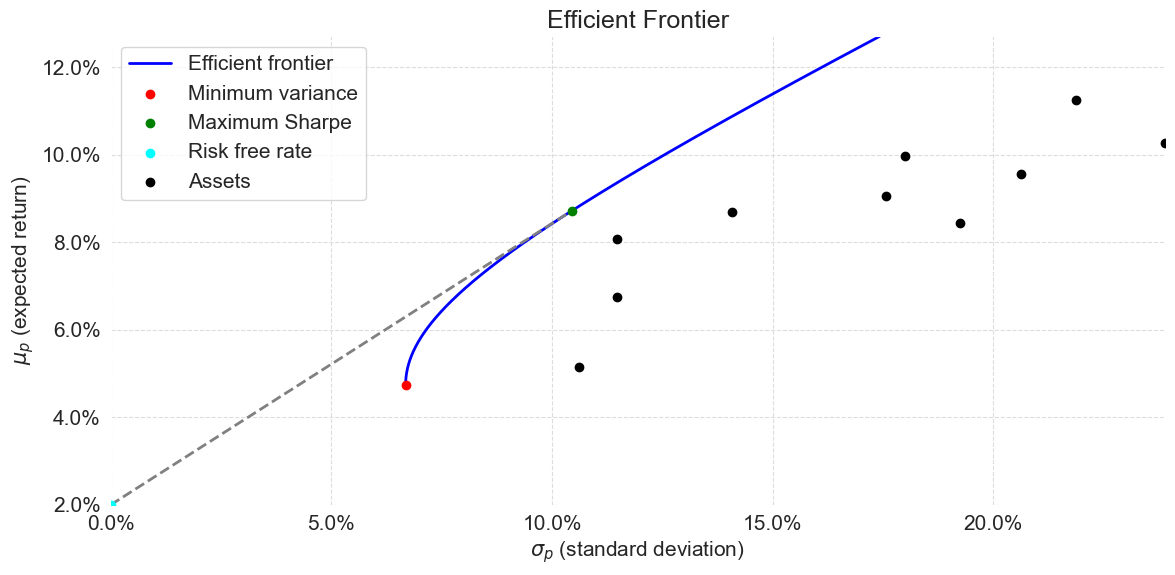

In [57]:
"""
Plot the efficient frontier
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient frontier")
ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_mv, mu_mv, color="red", label="Minimum variance", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="Maximum Sharpe", zorder=10)
ax.scatter(0, rf, color="cyan", label="Risk free rate", zorder=10)
ax.scatter(vols, mu, color="black", label="Assets", zorder=10)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.set_title("Efficient Frontier")
ax.set_xlabel("$\\sigma_p$ (standard deviation)")
ax.set_ylabel("$\\mu_p$ (expected return)")

ax.legend();

plt.tight_layout()

plt.savefig("efficient_frontier_example_10_assets.png", dpi=300)

## Estimation Uncertainty

### Simulate sample covariances and sample means

In [70]:
# set random seed for reproducibility
np.random.seed(42)

# number of assets
num_assets = 10

# generate random beta coefficients between 0.5 and 1.5
betas = np.random.uniform(0.5, 1.5, num_assets)

# market parameters
rf = 0.02 / 12  # risk-free rate
market_return = 0.08 / 12  # expected market return
market_excess_return = market_return - rf
market_std = 0.15  / np.sqrt(12) # market standard deviation

# draw idiosyncratic std for each asset between 0.05 and 0.1
idiosyncratic_stds = np.random.uniform(0.05 / np.sqrt(12), 0.1 / np.sqrt(12), num_assets)

# draw alpha for each asset between -0.01 and 0.03
alphas = np.random.uniform(-0.03 / 12, 0.03 / 12, num_assets)

# calculate vector of expected returns and covariance matrix
mu = alphas + rf + betas * market_excess_return
mu_excess = mu - rf
cov_mat = np.diag(idiosyncratic_stds**2) + np.outer(betas, betas) * market_std**2
corr_mat = cov_to_corr_matrix(cov_mat)
vols = np.sqrt(np.diag(cov_mat))

In [66]:
num_sim = 10_000
sample_size = 240

sim_mu = stats.multivariate_normal.rvs(mean=mu, cov=cov_mat / sample_size, size=num_sim)
sim_mu_excess = sim_mu - rf
sim_cov_mat = stats.wishart.rvs(df = sample_size-1, scale = cov_mat / sample_size, size=num_sim)
sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

### Portfolio optimization under estimation uncertainty

In [67]:
lam = 5.0

def calculate_mvo(mu: np.ndarray, cov_mat: np.ndarray, lam: float = 5.0):

    """
    Calculates the minimum-variance portfolio weights.

    Parameters
    ----------

    mu:
        Expected return vector.
    cov_mat:
        The covariance matrix.
    lam:
        Risk aversion parameter.

    Returns
    -------
    np.ndarray
        Mean-variance optimal portfolio weights.

    """

    return np.linalg.inv(cov_mat) @ mu / lam

def calculate_loss(mu: np.ndarray, cov_mat: np.ndarray, w: np.ndarray, lam: float = 5.0):

    """
    Calculates the mean-variance loss.

    Parameters
    ----------

    mu:
        Expected return vector.
    cov_mat:
        The covariance matrix.
    w:
        Portfolio weights.
    lam:
        Risk aversion parameter.

    Returns
    -------
    float
        Mean-variance loss.

    """

    w_true = calculate_mvo(mu, cov_mat, lam)
    mu_port_true = portfolio_mean(w_true, mu)
    var_port_true = portfolio_variance(w_true, cov_mat)
    ceq_true = mu_port_true - 0.5 * lam * var_port_true

    mu_port_est = portfolio_mean(w, mu)
    var_port_est = portfolio_variance(w, cov_mat)
    ceq_est = mu_port_est - 0.5 * lam * var_port_est

    loss = ceq_true - ceq_est

    return loss

In [68]:
sim_w_mvo = np.array([calculate_mvo(sim_mu_excess[i], sim_cov_mat[i], lam) for i in range(num_sim)])
sim_loss = np.array([calculate_loss(mu_excess, cov_mat, sim_w_mvo[i], lam) for i in range(num_sim)])

loss_eq_w = calculate_loss(mu_excess, cov_mat, np.repeat(1 / num_assets, num_assets), lam)

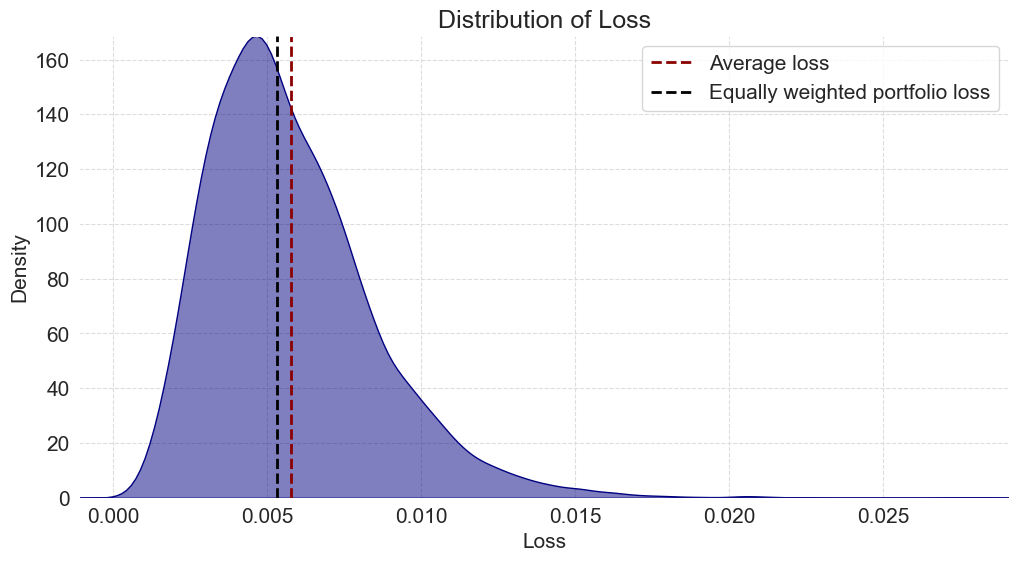

In [75]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(sim_loss, fill=True, ax=ax, color="navy", alpha=0.5)
ax.axvline(x=np.average(sim_loss), color="darkred", linestyle="--", label="Average loss")
ax.axvline(x=loss_eq_w, color="black", linestyle="--", label="Equally weighted portfolio loss", zorder=10)

ax.legend()
ax.set_title("Distribution of Loss")
ax.set_xlabel("Loss")
ax.set_ylabel("Density")

plt.tight_layout

plt.savefig("loss_distribution_example.png", dpi=300)
